# ISLES 2022 UNet


In [1]:
import os
import gc
import glob
from pathlib import Path

import numpy as np
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    Rotated,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Rotate90d,
    RandRotated,
    RandShiftIntensityd,
    RandGaussianNoised
)
from monai.handlers.utils import from_engine

from UNet3D import UNet
from AttUNet import AttUNet
from TransUNet import TransUNet
from monai.networks.nets import SwinUNETR

from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

In [2]:
def get_paths(mask):
    data_dir = os.path.join(os.getcwd(), 'data/train')
    tmp = []
    for path in Path(data_dir).rglob(mask):
        tmp.append(path.resolve())
    return tmp

In [3]:
training_dir = os.path.join(os.getcwd(), 'metrics')

image_paths = get_paths('*T1w*')
label_paths = get_paths('*mask*')

# To ensure I am not pulling in the training set with no mask/labels
assert(len(image_paths) == len(label_paths))
data_length = len(image_paths)

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(image_paths, label_paths)
]

# Because, why not? 
assert(len(data_dicts) == data_length)

from torch.utils.data import random_split

# Create train and validation sets
data_len = len(data_dicts)
val_len = int(data_len / 10)*2
train_len = data_len - val_len
train_files, val_files = random_split(data_dicts, [train_len, val_len])

In [4]:
print(len(train_files))
print(len(val_files))

525
130


# Transforms using Monai

In [45]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), # Load image file or files from provided path based on reader.
        EnsureChannelFirstd(keys=["image", "label"]), #adds a channel dimension if the data doesn't have one ... torch.Size([1, ...]) = torch.Size([1, 1, ...
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Rotate90d(keys=["image", "label"], k=1, spatial_axes=(0,2)), # rotate data so it looks like it should do? ... doesn't feel right when viewing otherwise
        ScaleIntensityRanged(
            keys=["image"], a_min=0.0, a_max=302.0,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        # RandRotated(keys=["image", "label"], prob=1, range_x=0.3),
        # RandRotated(keys=["image", "label"], prob=0.2, range_y=0.3),
        # RandRotated(keys=["image", "label"], prob=0.2, range_z=0.3),
        # RandShiftIntensityd(
        #     keys=["image"],
        #     offsets=0.30,
        #     prob=1,
        # ),
        RandGaussianNoised(keys=["image"], prob=1),
        EnsureTyped(keys=["image", "label"]) # converts the data to a pytorch tensor
    ]
)

        
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), # Load image file or files from provided path based on reader.
        EnsureChannelFirstd(keys=["image", "label"]), #adds a channel dimension if the data doesn't have one ... torch.Size([1, ...]) = torch.Size([1, 1, ...
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Rotate90d(keys=["image", "label"], k=1, spatial_axes=(0,2)), # rotate data so it looks like it should do? ... doesn't feel right when viewing otherwise
        ScaleIntensityRanged(
            keys=["image"], a_min=0.0, a_max=302.0,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        EnsureTyped(keys=["image", "label"]) # converts the data to a pytorch tensor
    ]
)
        
cropper = RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=(96, 96, 96),   # provides size of each image within the batch
    pos=1,      # pos / (pos + neg) = ratio of postivie and negative samples picked... 
    neg=1,      # with pos = neg = 1, ratio = 0.5 so it picks equal pos (stoke) and neg (no stroke) for sample.
    num_samples=4,   # number of smaller volumes to create from the original volume
    image_key="image",
    image_threshold=0,
)

In [6]:
# check_ds = Dataset(data=val_files, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")

image shape: (189, 233, 197), label shape: (189, 233, 197)


In [50]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

image shape: (189, 233, 197), label shape: (189, 233, 197)


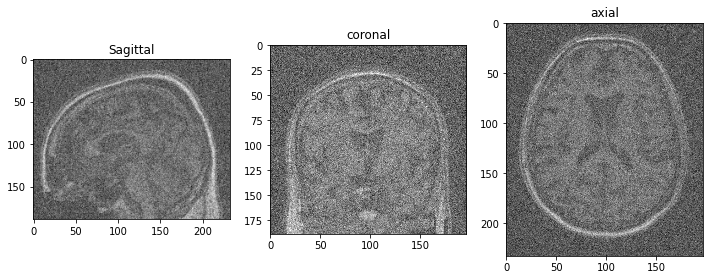

In [51]:
# Does the data look right?
plt.figure("check", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Sagittal")
plt.imshow(image[:,:,100], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("coronal")
plt.imshow(image[:,100,:], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("axial")
plt.imshow(image[100,:,:], cmap="gray")
plt.savefig('noise-transforms.png')
plt.show()